In [1]:
path_data = "data/chess_moves"


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

# from torchsummary import summary

# import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display

/home/bradicic/miniconda/envs/deep_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(0)
np.random.seed(0)

cuda


In [4]:
BATCH_SIZE = 64
LR = 5e-5
NUM_EPOCHES = 25
IMG_DIM = (96, 96)
                              

In [5]:
# Add the parent directory of 'vit' to sys.path
import sys
sys.path.append("..")
path_chess_moves = "../src/data_generation/all_moves_proba.txt"


In [6]:
class SimpleTokenizer:
    def __init__(self, vocab, max_size):
        self.vocab = vocab
        self.vocab['_'] = 0
        self.rev_vocab = {v: k for k, v in vocab.items()}
        self.max_size = max_size
    
    def encode(self, text):
        while len(text) < self.max_size:
            text += "_"
        return np.array([self.vocab[char] for char in text])
    
    def decode(self, tokens):
        return ''.join([self.rev_vocab[token] for token in tokens])


In [7]:
import sys
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import csv


class GrayscaleTransform:
    def __call__(self, rgb_image):
        weights = torch.tensor([0.299, 0.587, 0.114], dtype=torch.float32)
        return torch.einsum('chw,c->hw', rgb_image, weights)


class ChessDataset(Dataset):
    def __init__(self, img_dir, input_dim, file_ids, tokenizer):
        self.img_dir = img_dir
        self.img_extention = ".png"
        self.label_extention = ".txt"
        self.list_of_files = file_ids
        self.transform = transforms.Compose([
                            transforms.ConvertImageDtype(torch.float),
                            # transforms.Grayscale(num_output_channels=3),
                            transforms.CenterCrop(input_dim),
                            # transforms.Resize((80,192)),
                            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                            GrayscaleTransform(),
                            ])
        self.tokenizer = tokenizer
        
    def __len__(self,):
        return len(self.list_of_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, (self.list_of_files[idx] + self.img_extention))
        label_path = os.path.join(self.img_dir,  (self.list_of_files[idx] + self.label_extention))

        #Img
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
            image = image.unsqueeze(0)
            image = image.repeat(3, 1, 1)
            
        # Label
        f = open(label_path, "r")
        label = f.read()
        label = self.tokenizer.encode(label)
        label = torch.from_numpy(label)

        return image, label

In [8]:
def get_bag_of_characters(path, return_max=False):
    bag_of_strings = np.array([])
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            bag_of_strings = np.append(bag_of_strings, row[0])

    unique_characters = set(''.join(bag_of_strings))
    unique_string = ''.join(sorted(unique_characters))

    if return_max:
        max_size = max([len(x) for x in bag_of_strings])
        return unique_string, max_size
    else:
        return unique_string
    
def get_image_ids(path):
    file_names = os.listdir(path)
    files = [f[:-4] for f in file_names if f.endswith(".png")]
    return files

def split_array(arr, ratio):
    # Ensure the array is a numpy array for easy slicing
    arr = np.array(arr)
    
    # Calculate the split index
    split_idx = int(len(arr) * ratio)
    
    # Split the array
    part1 = arr[:split_idx]
    part2 = arr[split_idx:]
    
    return part1, part2

In [9]:
dictionary_path = os.path.join("..", "data", "chess_moves")

img_ids = get_image_ids(dictionary_path)

train_ids, val_ids = split_array(img_ids,ratio=0.8)

In [10]:
# Creating vocabular
temp_vocab, MAX_LENGTH = get_bag_of_characters(path_chess_moves, return_max=True)
vocab = {char: idx for idx, char in enumerate(temp_vocab, 1)}
tokenizer = SimpleTokenizer(vocab, MAX_LENGTH)
NUM_CLASSES = len(vocab)

# Creating dataset
train_dataset = ChessDataset(dictionary_path, IMG_DIM, train_ids, tokenizer)
val_dataset = ChessDataset(dictionary_path, IMG_DIM, val_ids, tokenizer)

# Creating dataloader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

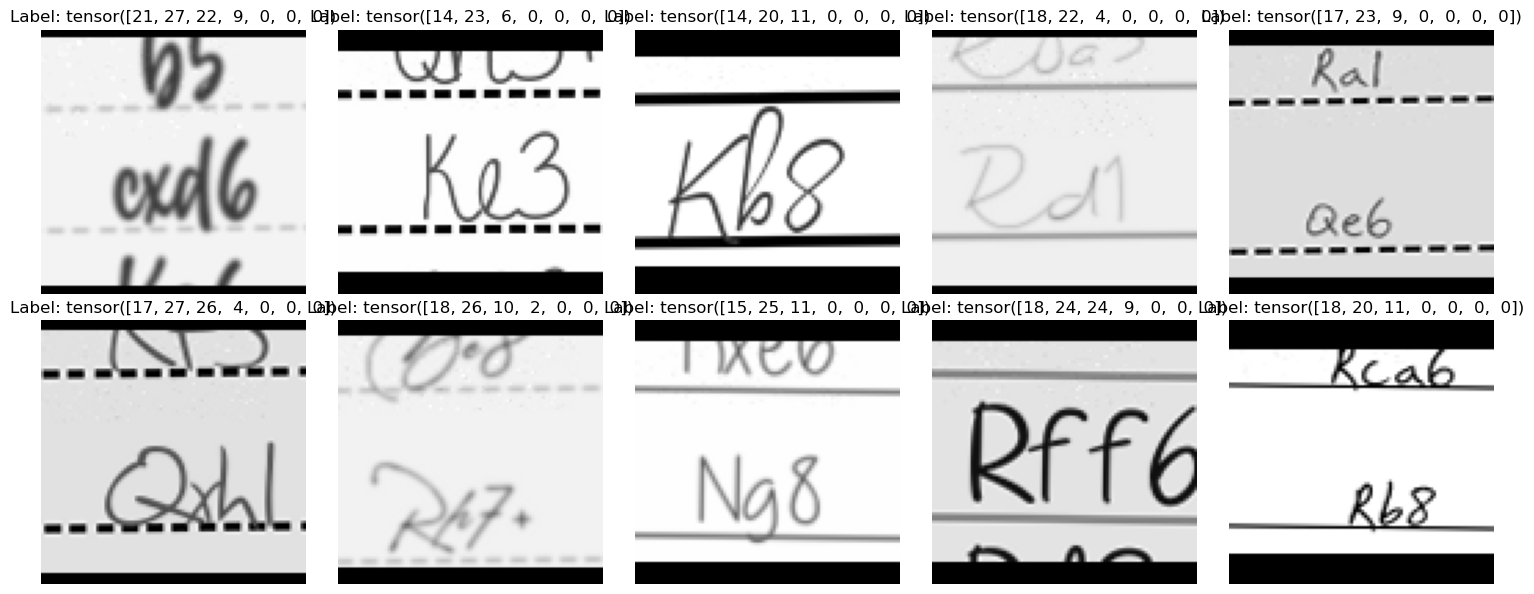

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in range(10):
    # Select the first channel (i.e., grayscale image) if it's a multi-channel image
    axes[i].imshow(train_dataset[i][0][0,:,:], cmap="gray")
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f"Label: {train_dataset[i][1]}")  # Set title for each image

plt.tight_layout()  # Adjust spacing between images
plt.show()

In [12]:
import sys
sys.path.append("..")

from architecture.transformer import ViT

In [13]:
image_size = 96
channel_size = 3
patch_size = 8
embed_size = 512
num_heads = 8
classes = 28
num_layers = 3
hidden_size = 256
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=192, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): L

In [ ]:
x,y = next(iter(val_dataloader))
out = model(x.to(device))

tensor([[[-0.0906,  0.3445, -1.4303,  ..., -0.8442,  0.5677,  0.7148],
         [-0.5917, -0.4119, -1.2036,  ...,  1.1580,  0.5772, -0.7500],
         [ 0.2950,  0.3893, -1.4541,  ..., -0.1311,  1.0537, -0.2962],
         ...,
         [-0.0810, -0.3034,  0.1785,  ...,  0.4129,  0.2690, -0.3746],
         [ 0.8454, -0.3618, -0.1881,  ...,  0.8033, -0.4140,  0.5928],
         [ 1.2157, -0.4810, -0.1281,  ...,  0.7321,  0.6721, -0.6580]],

        [[ 0.7556,  0.0820, -1.2817,  ..., -0.5806,  0.6356,  0.3507],
         [-0.7570,  0.3206, -1.4767,  ...,  0.4491, -0.1964, -0.8140],
         [-0.0055,  0.5461, -1.1855,  ...,  0.1323,  0.2047, -0.3177],
         ...,
         [ 0.2912, -0.5822, -0.1614,  ..., -0.0576, -0.0572, -0.0225],
         [ 0.6709,  0.1651,  0.1086,  ...,  0.6760, -0.0200,  0.8066],
         [ 0.9413,  0.4724,  0.2050,  ...,  0.3834,  1.2163, -0.2293]],

        [[-0.1156, -0.3449, -1.2512,  ..., -0.0986,  0.4662,  0.5134],
         [-0.4062, -0.4571, -1.0784,  ...,  0

In [ ]:
# # Define the model
# class ViTSequenceClassifier(nn.Module):
#     def __init__(self, num_classes=28, max_length=7):
#         super().__init__()
#         self.max_length = max_length

#         # Load a pretrained ViT backbone
#         self.backbone = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
#         self.hidden_size = self.backbone.config.hidden_size

#         # Classification heads for each sequence position
#         self.classifiers = nn.ModuleList([
#             nn.Linear(self.hidden_size, num_classes) for _ in range(max_length)
#         ])

#     def forward(self, pixel_values):
#         # Extract features from the image
#         outputs = self.backbone(pixel_values=pixel_values)
#         features = outputs.pooler_output  # Shape: (batch_size, hidden_size)

#         # Apply classification heads
#         logits = torch.stack([classifier(features) for classifier in self.classifiers], dim=1)
#         return logits  # Shape: (batch_size, max_length, num_classes)

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for pixel_values, labels in dataloader:
            pixel_values, labels = pixel_values.to(device), labels.to(device)
            
            logits = model(pixel_values)

            loss = 0
            for i in range(model.max_length):
                loss += criterion(logits[:, i, :], labels[:, i])
            
            total_loss += loss
    return total_loss/(len(dataloader) * BATCH_SIZE)      

In [20]:
from tqdm import tqdm
loss_hist = {}
loss_hist["train_loss"] = []
loss_hist["val_loss"] = []
loss_hist["train_loss_iterations"] = []


def train_model(model, train_dl, validation_dl, optimizer, criterion, device, epochs=10):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        counter = 0

        for pixel_values, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            pixel_values, labels = pixel_values.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(pixel_values)

            loss = 0
            for i in range(MAX_LENGTH):
                loss += criterion(logits[:, i, :], labels[:, i])

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            counter +=1 
            loss_hist["train_loss_iterations"].append(total_loss/(counter * BATCH_SIZE))
                
        #Logging 
        loss_train = total_loss/(len(train_dataloader) * BATCH_SIZE)
        loss_hist["train_loss"].append(loss_train)

        #Evaluating on val
        loss_val = evaluate_model(model, validation_dl, criterion)
        loss_hist["val_loss"].append(loss_val)

        #Save model
        name = f"model_{epoch}.pth"
        path = "saved/"
        torch.save(model.state_dict(), os.path.join(path, name))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss_train:.8f}, Val Loss: {loss_val:.8f}")

In [21]:
# from transformers import ViTModel, ViTConfig, ViTFeatureExtractor

# # Initialize the processor (for resizing and normalizing images)
# processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# model = ViTSequenceClassifier(num_classes=NUM_CLASSES, max_length=MAX_LENGTH).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [22]:
# Train the model
train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=NUM_EPOCHES)

Epoch 1/25: 100%|██████████| 579/579 [03:19<00:00,  2.90batch/s]


NameError: name 'evaluate_model' is not defined

In [21]:
model.load_state_dict(torch.load("saved/model_8.pth", weights_only=True))


<All keys matched successfully>

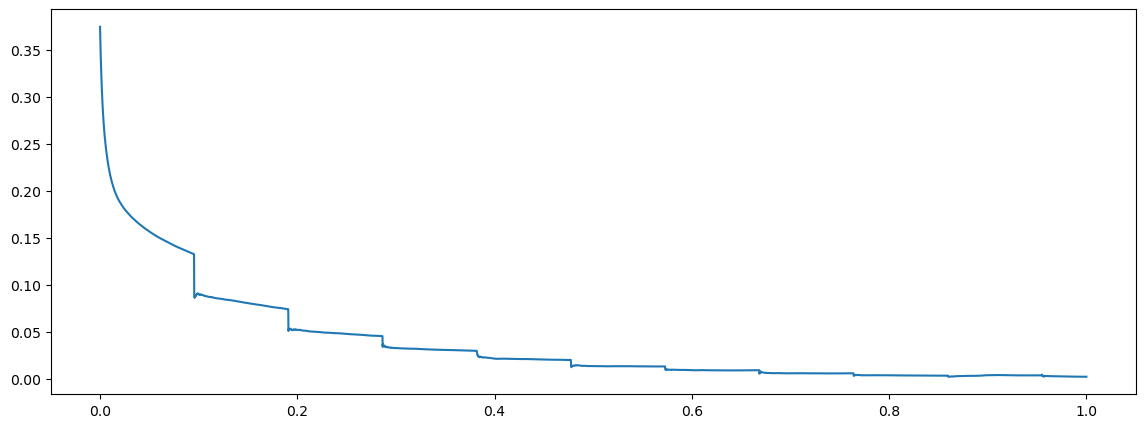

In [27]:
fig,ax = plt.subplots(1,1, figsize=(14,5))

ax.plot(np.linspace(0,1,len(loss_hist["train_loss_iterations"])), loss_hist["train_loss_iterations"])

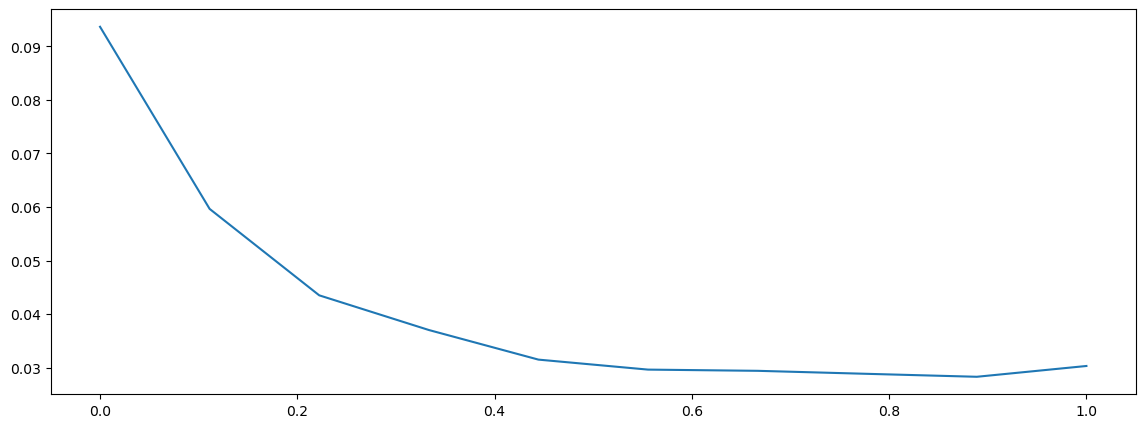

In [28]:
fig,ax = plt.subplots(1,1, figsize=(14,5))

ax.plot(np.linspace(0,1,len(loss_hist["val_loss"])), [x.to("cpu").numpy() for x in loss_hist["val_loss"]])

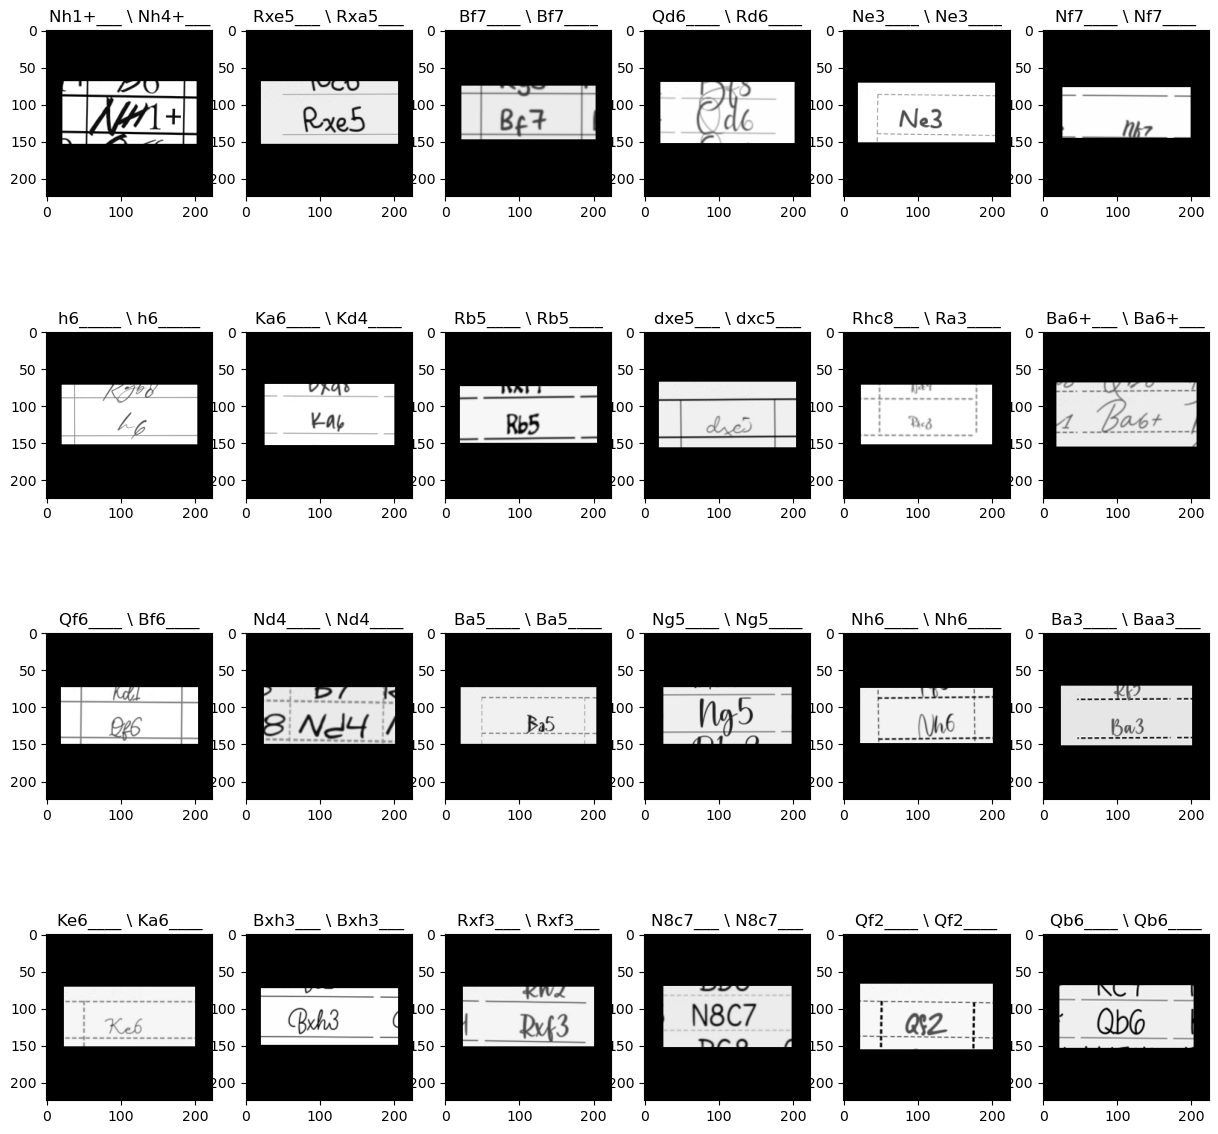

In [22]:
figs = (4,6)
x,y = next(iter(val_dataloader))
out = model(x.to(device))
out = torch.argmax(out,dim=2)

fig, ax = plt.subplots(figs[0], figs[1], figsize=(15,15))
ax = ax.flatten()
for i in range(0,figs[0]*figs[1]):
    ax[i].imshow(x[i][0,:,:], cmap="gray")
    pred = tokenizer.decode(out[i].cpu().numpy())
    true = tokenizer.decode(y[i].cpu().numpy())
    ax[i].set_title(f"{true} \ {pred}")


In [ ]:
#### EVALUATION ON TEST
path = "data/test_data/images"

In [94]:
class TestDataset(Dataset):
    def __init__(self, validation_csv_path, img_dir_path, tokenizer, input_dim):
        self.validation_csv_path = validation_csv_path
        self.img_dir_path = img_dir_path
        self.tokenizer = tokenizer
        self.input_dim = input_dim

        self.file_names, self.labels = self.__read_csv()
        self.transform = transforms.Compose([
                            transforms.ConvertImageDtype(torch.float),
                            transforms.CenterCrop(self.input_dim),
                            GrayscaleTransform(),
                            ])

    def __read_csv(self):
        file_names = np.array([])
        labels = np.array([])
        with open(self.validation_csv_path, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                ext = row[0][-4:]
                if ext in [".png",".jpe"]:
                    file_name = row[0].split("/")[-1]
                    file_label = row[1]

                    file_names = np.append(file_names, file_name)
                    labels = np.append(labels, file_label)

        return file_names, labels
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir_path, (self.file_names[index]))
        
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
            image = image.unsqueeze(0)
            image = image.repeat(3, 1, 1)

        label = self.labels[index]
        label = self.tokenizer.encode(label)
        label = torch.from_numpy(label)

        return image, label
    
    def __len__(self,):
        return len(self.file_names)

In [147]:
path_csv = "../data/test_data/val.csv"
path_test_images = "../data/test_data/images"
test_dataset = TestDataset(path_csv, path_test_images, tokenizer, IMG_DIM)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [150]:
@torch.no_grad()
def evaluate_test():
    sum = 0
    for x,y in test_dataloader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        out = torch.argmax(out, dim=2)
        out = out.cpu().numpy()
        y = y.cpu().numpy()
        sum += np.sum(np.all(out == y, axis=1))
        
    return sum

model.load_state_dict(torch.load("saved/model_9.pth", weights_only=True))
evaluate_test()

441

In [152]:
441/len(test_dataset)

0.3305847076461769